# Лабораторная работа №4. Нелинейная краевая задача.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Постановка задачи

Рассматривается краевая задача для обыкновенного дифференциального уравнения второго порядка:

$ y'' + p x \cos(y) = 0, \quad 0 \leq x \leq 1, $

с граничными условиями:

$ y'(0) = 0, \quad y(1) = 0, $

где $ p $ — параметр, принимающий значения $ p = 1, 4, 7, 25, 50, 100 $.

In [2]:
# Func for shooting method: u = [y, z], u' = [z, -p*x*cos(y)]
def f_shooting(t, u, p):
    return np.array([u[1], -p * t * np.cos(u[0])])

# Func for quasilinearization: u = [y, z], u' = [z, b(t) - a(t)*y]
def f_quasi(t, u, p, a, b):
    return np.array([u[1], b(t) - a(t) * u[0]])

# Parameters
a = 0.0
b = 1.0
N = 1000
eps = 1e-6
max_iter = 800 # default value
p_values = [1, 4, 7, 25, 50, 100]
s0 = 0.0
s1 = 2.0

In [3]:
# RK4 for one step of solve_cauchy function
def explicit_RK4(t, y, h, p, f, a=None, b=None):
    k1 = f(t, y, p) if a is None else f(t, y, p, a, b)
    k2 = f(t + h/2, y + h/2 * k1, p) if a is None else f(t + h/2, y + h/2 * k1, p, a, b)
    k3 = f(t + h/2, y + h/2 * k2, p) if a is None else f(t + h/2, y + h/2 * k2, p, a, b)
    k4 = f(t + h, y + h * k3, p) if a is None else f(t + h, y + h * k3, p, a, b)
    result = np.zeros(2)
    for i in range(2):
        result[i] = y[i] + h/6 * (k1[i] + 2*k2[i] + 2*k3[i] + k4[i])
    return result

# Solving Cauchy's problem
def solve_cauchy(a, b, s, p, N, f, a_func=None, b_func=None):
    h = (b - a) / N
    x = np.zeros(N+1)
    u = np.zeros((2, N+1))
    
    for i in range(N+1):
        x[i] = a + i * h
    
    u[0, 0] = s
    u[1, 0] = 0
    
    for i in range(N):
        u[:, i+1] = explicit_RK4(x[i], u[:, i], h, p, f, a_func, b_func)
    
    return x, u[0, :], u[1, :]

# Residual function F(s) = y(1; s)
def residual(s, a, b, p, N, f, a_func=None, b_func=None):
    x, y, z = solve_cauchy(a, b, s, p, N, f, a_func, b_func)
    return y[N]

def is_zero(value):
    if abs(value) < eps:
        return 0.0
    else:
        return value

### 1. Метод стрельбы

Метод стрельбы преобразует краевую задачу в задачу Коши путем подбора начального условия $ y(0) = s $, чтобы обеспечить выполнение $ y(1) = 0 $.

1. **Преобразование уравнения**:
   - Уравнение $ y'' = -p x \cos(y) $ записывается как система ОДУ первого порядка:
     $ y' = z, \quad z' = -p x \cos(y). $
   - Начальные условия: $ y(0) = s $, $ z(0) = y'(0) = 0 $.

2. **Численное интегрирование**:
   - Система решается методом RK4 (классический Рунге-Кутты) на отрезке $ [0, 1] $ с шагом $ h = \frac{1}{N} $ ($ N = 2000 $).

3. **Подбор $ s $**:
   - Определяется невязка: $ F(s) = y(1; s) $.
   - Значение $ s $ подбирается методом секущих:
     $ s_{n+1} = s_n - F(s_n) \cdot \frac{s_n - s_{n-1}}{F(s_n) - F(s_{n-1})}. $
   - Итерации продолжаются, пока $ |F(s)| < \varepsilon $ ($ \varepsilon = 10^{-6} $).

4. **Начальные предположения**:
   - $ s_0 = 0.5 $, $ s_1 = 1.0 $, чтобы направить сходимость к положительной ветви ($ y(0) > 0 $).
---

### 2. Метод квазилинеаризации Ньютона

Метод квазилинеаризации линеаризует нелинейное уравнение на каждой итерации, решая последовательность линейных краевых задач, и использует метод Ньютона для ускорения сходимости.

1. **Линеаризация**:
   - Исходное уравнение: $ y'' = -p x \cos(y) $.
   - Обозначим $ F(y) = p x \cos(y) $, тогда $ F'(y) = -p x \sin(y) $.
   - На $ n $-й итерации линеаризуем около текущего приближения $ y_n(x) $:
     $ y_{n+1}'' = -F(y_{n+1}) \approx -F(y_n) - F'(y_n)(y_{n+1} - y_n). $
   - Получаем линейное уравнение:
     $ y_{n+1}'' - p x \sin(y_n) y_{n+1} = -p x [\sin(y_n) y_n + \cos(y_n)]. $
   - Коэффициенты: $ a(x) = -p x \sin(y_n) $, $ b(x) = -p x [\sin(y_n) y_n + \cos(y_n)] $.

2. **Решение линейной задачи**:
   - Линейное уравнение $ y_{n+1}'' + a(x) y_{n+1} = b(x) $ решается методом стрельбы:
     - Система: $ y_{n+1}' = z $, $ z' = b(x) - a(x) y_{n+1} $.
     - Начальные условия: $ y_{n+1}(0) = s $, $ z(0) = 0 $.
     - Подбирается $ s $, чтобы $ y_{n+1}(1) = 0 $.
   - Интегрирование выполняется методом RK4.

3. **Итерации Ньютона**:
   - Проверяется сходимость: $ \max |y_{n+1}(x) - y_n(x)| < \varepsilon $.
   - Обновляется $ y_n = y_{n+1} $.

4. **Начальное приближение**:
   - $ y_0(x) = 0.0 $
---


In [4]:
# Shooting method with secant method
def shooting_method(a, b, p, s0, s1, eps, max_iter, N, f, a_func=None, b_func=None):
    s_prev = s0
    s_curr = s1
    F_prev = residual(s_prev, a, b, p, N, f, a_func, b_func)
    
    for n in range(max_iter):
        F_curr = residual(s_curr, a, b, p, N, f, a_func, b_func)
        if abs(F_curr) < eps:
            x, y, z = solve_cauchy(a, b, s_curr, p, N, f, a_func, b_func)
            return x, y, s_curr
        
        s_next = s_curr - F_curr * (s_curr - s_prev) / (F_curr - F_prev)
        s_prev = s_curr
        F_prev = F_curr
        s_curr = s_next
    
    print(f"Shooting method: did not converge with p = {p}")
    return None, None, None

# Newton's quasilinearization method
def quasilinearization(a, b, p, y0, eps, max_iter, N, s0, s1):
    h = (b - a) / N
    x = np.zeros(N+1)
    for i in range(N+1):
        x[i] = a + i * h
    
    y_n = np.copy(y0)
    y_np1 = np.zeros(N+1)
    
    for n in range(max_iter):
        # Calculate a(x) = -p*x*sin(y_n), b(x) = -p*x*(sin(y_n)*y_n + cos(y_n))
        a_func = lambda t: -p * t * np.sin(y_n[int((t - a) / h)])
        b_func = lambda t: -p * t * (np.sin(y_n[int((t - a) / h)]) * y_n[int((t - a) / h)] + np.cos(y_n[int((t - a) / h)]))
        
        # Solving linearized problem with shooting method
        x, y_np1, s = shooting_method(a, b, p, s0, s1, eps, 100, N, f_quasi, a_func, b_func)
        if x is None:
            print(f"Quasilinearization: did not converge with p = {p}")
            return None, None, None
        
        # Check, does it converge or not
        max_diff = 0.0
        for i in range(N+1):
            diff = abs(y_np1[i] - y_n[i])
            if diff > max_diff:
                max_diff = diff
        
        if max_diff < eps:
            return x, y_np1, s
        
        # Update y_n
        for i in range(N+1):
            y_n[i] = y_np1[i]
    
    print(f"Quasilinearization: did not converge with p = {p}")
    return None, None, None

Shooting method: p = 1: y(0) = 0.165116, y(1) = 0.000000
Shooting method: p = 4: y(0) = 0.588592, y(1) = 0.000000
Shooting method: p = 7: y(0) = 0.870753, y(1) = 0.000000
Shooting method: p = 25: y(0) = 1.404875, y(1) = 0.000000
Shooting method: p = 50: y(0) = -3.913006, y(1) = 0.000000
Shooting method: p = 100: y(0) = 1.564107, y(1) = 0.000000
Quasilinearization method: p = 1: y(0) = 0.165116, y(1) = 0.000000
Quasilinearization method: p = 4: y(0) = 0.588592, y(1) = 0.000000
Quasilinearization method: p = 7: y(0) = 0.870754, y(1) = 0.000000
Quasilinearization method: p = 25: y(0) = 1.404875, y(1) = 0.000000
Quasilinearization method: p = 50: y(0) = -3.913006, y(1) = 0.000000
Quasilinearization method: p = 100: y(0) = 1.564107, y(1) = 0.000000


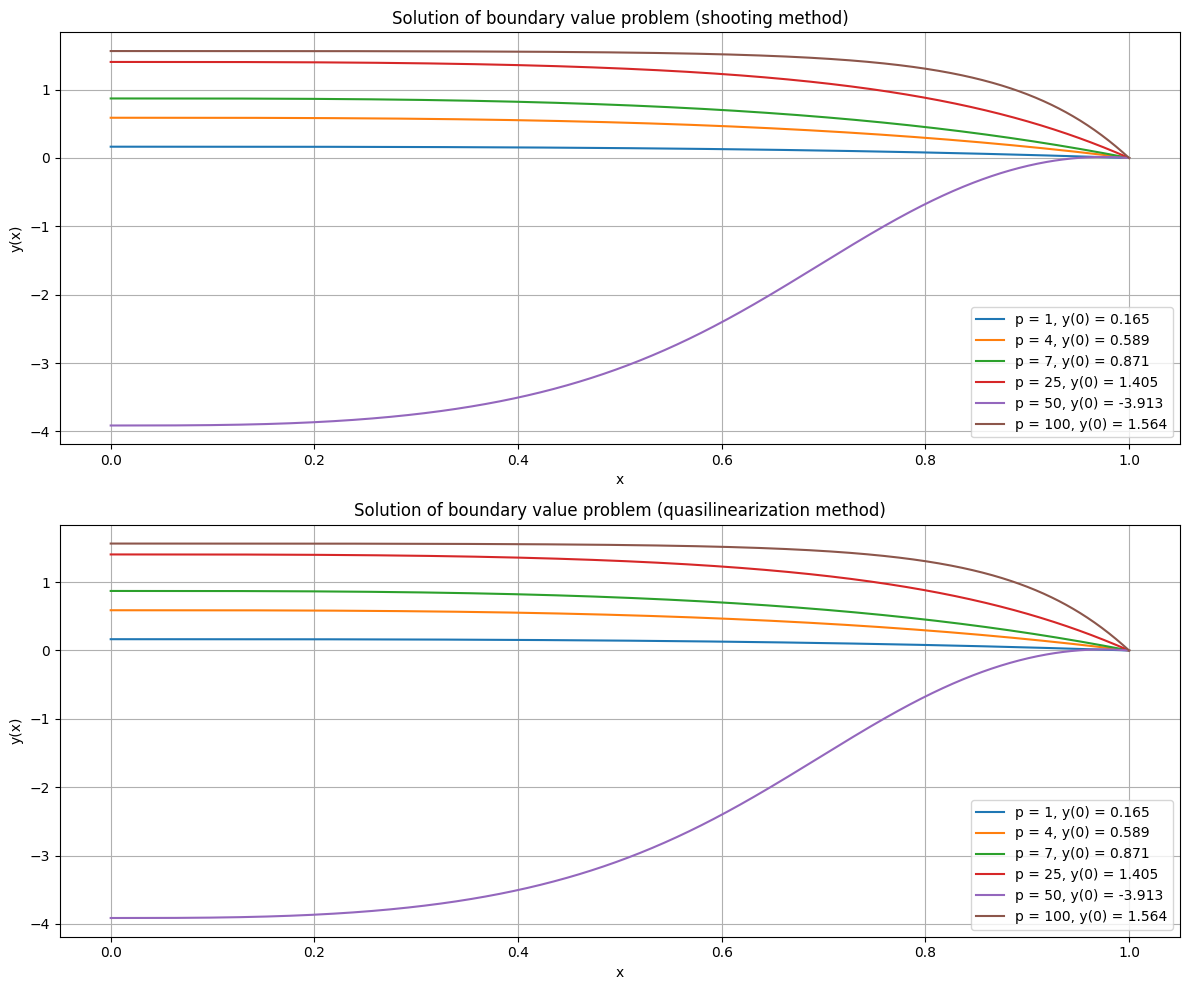

In [5]:

# y_0 quasilinearization
y0 = np.zeros(N+1)

# Arrays for solutions
solutions_shooting = []
solutions_quasi = []

max_iter = 400
# Solution using shooting method
for p in p_values:
    x, y, s = shooting_method(a, b, p, s0, s1, eps, max_iter, N, f_shooting)
    if x is not None:
        solutions_shooting.append((p, x, y, s))
        print(f"Shooting method: p = {p}: y(0) = {s:.6f}, y(1) = {is_zero(y[N]):.6f}")

max_iter = 100
# Solution using quasilinearization method
for p in p_values:
    x, y, s = quasilinearization(a, b, p, y0, eps, max_iter, N, s0, s1)
    if x is not None:
        solutions_quasi.append((p, x, y, s))
        print(f"Quasilinearization method: p = {p}: y(0) = {s:.6f}, y(1) = {is_zero(y[N]):.6f}")

plt.figure(figsize=(12, 10))

# Plot for shooting method
plt.subplot(2, 1, 1)
for p, x, y, s in solutions_shooting:
    plt.plot(x, y, label=f"p = {p}, y(0) = {s:.3f}")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Solution of boundary value problem (shooting method)")
plt.legend()
plt.grid(True)

# Plot for quasilinearization method
plt.subplot(2, 1, 2)
for p, x, y, s in solutions_quasi:
    plt.plot(x, y, label=f"p = {p}, y(0) = {s:.3f}")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Solution of boundary value problem (quasilinearization method)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Выводы
В данной лабораторной работе мы нашли численное решение исходной нелинейной краевой задачи при различных параметрах **p**. Использовались методы стрельбы и квазилианеризации Ньютона (линейная задача решалась при помощи метода стрельбы). Отметим, что метод стрельбы сходится линейно вследствие применения метода секущих, а метод квазилианеризации - квадратично благодаря методу Ньютона, поэтому для сходимости при **p = 100** первому методу требуется не менее **max_iter = 400** итераций, второму хватает и **max_iter  = 100** итераций. Также следует заметить (видно по графикам), что при **p = 50** была найдена отрицательная ветвь решения, в то время как остальные - положительные. Это связано с заданием начального приближения, которое в данном случае привело нас к этой ветви.